In [147]:
import sys
import os
import numpy as np
import time
# Add the parent folder to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import density_generator
import numpy as np
import matplotlib.pyplot as plt
import qutip
import importlib
import helper_functions
import classicalQFI
import quantum_subroutines_pennylane
import pipeline_v200
import vqfe_subroutine
import pennylane as qml
import circuit_generator
from scipy.linalg import eigh
#from pennylane import numpy as np

from random import randint
importlib.reload(density_generator)
importlib.reload(helper_functions)
importlib.reload(quantum_subroutines_pennylane)
importlib.reload(vqfe_subroutine)
importlib.reload(pipeline_v200)
importlib.reload(circuit_generator)
importlib.reload(classicalQFI)

pass;

In [72]:
## parameters
N=3
n=2
#trace_out_indices= list(range(N - n))
trace_out_indices = np.sort(np.random.choice(range(N), size= N - n, replace=False))
#trace_out_indices = [0]
J=1
#h_z=0.1
h_x=0.1
delta=0.5
delta_h_x=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3

print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
#print("h_z =",h_z)
print("h_x =",h_x)
print("delta_h_x =",delta_h_x)
print("delta =",delta)
print("m =",m)
print("DEBUG is set to: ",DEBUG)

N = 3  starting number of qubits, before tracing out
n = 2  final number of qubits
trace_out_indices = [0]
J = 1
h_x = 0.1
delta_h_x = 0.5
delta = 0.5
m = 1
DEBUG is set to:  False


In [73]:
trace_out_indices

array([0])

In [74]:
# classical
print("TEST 1 : classical\n")
#model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG) 
## using N because i will trace out

rho_pure, rho_delta_pure = model.generate_perturbed_density_matrices(delta_h_x==delta_h_x)
print("rho_pure shape = ", rho_pure.shape)
evals = np.linalg.eigvalsh(rho_pure)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)


rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(delta_h_x=delta_h_x,trace_out_indices=trace_out_indices)
print("rho_mixed shape = ", rho_mixed.shape)
print("purity of rho", np.trace(rho_mixed @ rho_mixed))
print("purity of rho_delta", np.trace(rho_delta_mixed @ rho_delta_mixed))

evals = np.linalg.eigvalsh(rho_mixed)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)

print("uhlmann fidelity = ", helper_functions.uhlmann_fidelity_root(rho_mixed, rho_delta_mixed))
print("fidelity pennylane = ",helper_functions.fidelity_pennylane(rho_mixed, rho_delta_mixed))


TEST 1 : classical



TypeError: TransverseFieldIsingModel.generate_perturbed_density_matrices() missing 1 required positional argument: 'time'

TEST 2 : quantum



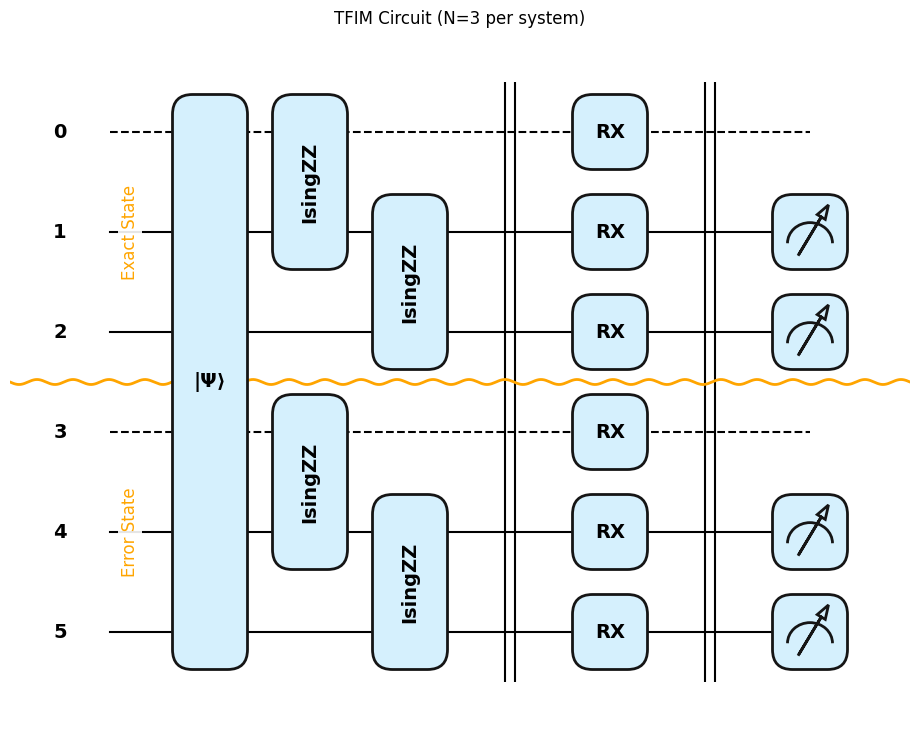

In [75]:
print("TEST 2 : quantum\n")

DRAW = True



circuit_fn = circuit_generator.make_tfim_circuits(J, h_x, delta, N) 

# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)

# --- Construct measured_wires ---
# These calculations correctly generate integer wire indices IF N is an int
# and trace_out_indices contains only ints.
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho] # Adds N (integer) to each active_rho (integer)

measured_wires = active_rho + active_rho_delta # Concatenates lists of integers
discarded_wires = [x for x in range(2*N) if x not in measured_wires] # Filters from integers


@qml.qnode(dev)
def qnode():
    circuit_fn()
    # It is crucial that `measured_wires` contains only integers or a single integer.
    # The TypeError "got '0.2'" means a float ended up in this list.
    return qml.density_matrix(wires=measured_wires) # This is where the error occurs


# --- Print the Circuit ---
wire_options = {
    i: {'linestyle': '--'} for i in discarded_wires # Highlight discarded wires
}

if DRAW:
    # Get the drawing function. Call it to get the fig and ax objects.
    # The `()` at the end is correct to call the drawing function.
    fig, ax = qml.draw_mpl(qnode, style="pennylane", wire_options=wire_options)()

    # --- Add a horizontal line at half of the plot ---
    # The wires are drawn from top (wire 0) to bottom (wire 2*N - 1).
    # The line should be between the N-th qubit and the (N+1)-th qubit (0-indexed).
    # Its y-coordinate will be N - 0.5 (assuming wire 0 is at y=0, wire 1 at y=1, etc.)
    
    # Calculate the y-coordinate for the horizontal separator
    # 'N' here is the number of qubits in the first system
    separator_y = N - 0.5 
    
    # Add the horizontal line to the axes
    # Adjust xmin and xmax to make the line span the desired width.
    # These are normalized coordinates (0 to 1) relative to the axes' width.
    #ax.axhline(y=separator_y, color='red', linewidth=2.0, xmin=0.05, xmax=0.95)
    
    # dotted separator
    #ax.axhline(y=separator_y, color='red', linewidth=2.0, xmin=0.05, xmax=0.95,
    #       linestyle=(0, (1, 10))) # This makes it a dotted line, which can look "wavy" from a distance
    
    # --- Parameters for the sinusoidal line ---
    # `separator_y` is the central y-position for the wave
    # It sits between wire N-1 and wire N.
    separator_y = N - 0.5 
    
    # Get the x-limits of the plot to span the wave across the circuit
    x_min, x_max = ax.get_xlim() 

    # Amplitude of the wave (how "tall" it is). Adjust this to your liking.
    # A value between 0.1 and 0.3 usually looks good without overlapping wires.
    amplitude = 0.025

    # Frequency of the wave (how many cycles across the plot). Adjust this.
    # E.g., 5 cycles across the x_range.
    num_cycles = 25 
    
    # Generate x values for the sine wave. Use many points for a smooth curve.
    x_wave = np.linspace(x_min, x_max, 500) 

    # Calculate y values for the sine wave.
    # This formula creates a sine wave centered at `separator_y`
    # and scales it to fit `num_cycles` within the `x_min` to `x_max` range.
    y_wave = separator_y + amplitude * np.sin(2 * np.pi * num_cycles * (x_wave - x_min) / (x_max - x_min))

    # Plot the sinusoidal line
    ax.plot(x_wave, y_wave, color='orange', linewidth=2.0, linestyle='-') # Use solid linestyle for the wave

    # --- Add text labels ---
    # Adjust text position based on the diagram's layout and number of wires
    ax.text(-0.8, (N - 1)/2, 'Exact State', ha='center', va='center', fontsize=12, rotation=90, color='orange',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))
    ax.text(-0.8, N + (N - 1)/2, 'Error State', ha='center', va='center', fontsize=12, rotation=90,color='orange',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2 ))

    plt.title(f"TFIM Circuit (N={N} per system)")
    plt.show()

# You can still execute the QNode if needed:
# result_dm = qnode()
# print("\nResulting density matrix for measured wires:\n", np.round(result_dm, 4))
 

In [6]:
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=1, 
    maxiter=200)
vqfe_results


{'F_trunc': tensor(0.72745419, requires_grad=True),
 'F_star': tensor(0.79008679, requires_grad=True),
 'top_eigenvalues_rho': tensor([0.99158768], requires_grad=True),
 'trace_rho_m': tensor(0.99158768, requires_grad=True),
 'trace_sigma_m': 0.5336790868299524,
 'opt_params': array([[[-0.39910472,  0.06634616, -0.09771977],
         [-0.30459173, -0.27974343, -0.29005237]],
 
        [[-0.10031524, -0.02103869,  0.09042883],
         [-0.23036034,  0.39129604,  0.01254064]]]),
 'rho_rotated_final': array([[ 9.91587676e-01+1.12178502e-16j,  1.01605433e-03+1.46522127e-03j,
         -3.39670194e-02+7.81598453e-02j, -4.55156094e-03-3.24798495e-02j],
        [ 1.01605433e-03-1.46522127e-03j,  3.20621146e-06-2.29701732e-18j,
          8.06879034e-05+1.30279805e-04j, -5.26577737e-05-2.65556424e-05j],
        [-3.39670194e-02-7.81598453e-02j,  8.06879034e-05-1.30279805e-04j,
          7.32433451e-03-1.99980839e-19j, -2.40424232e-03+1.47137062e-03j],
        [-4.55156094e-03+3.24798495e-02j, -

In [10]:
# collect fidelities

## parameters
N=4
n=3
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=2
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]



results = []

for h_z in np.linspace(0, 2.5, 20):

    # classical fidelity
    # classical

    #model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
    model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG) 
    
    rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(delta_h_x=delta_h_x,trace_out_indices=trace_out_indices)

    classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)
    
    # quantum fidelity

    #circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 
    circuit_fn = circuit_generator.make_tfim_circuits(J, h_x, delta, N) 

    # Attach to a device and QNode
    dev = qml.device("default.qubit", wires=2 * N)
    vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
        circuit_fn = circuit_fn,
        total_num_qubits=2*N,
        active_rho_wires = active_rho, 
        active_rho_delta_wires = active_rho_delta,
        L=2, 
        m=m, 
        maxiter= 256)

    results.append({
        "hz": h_z,
        "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
        "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
        "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
        "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
        #"(Classical) Participation Ratio" : classical_results["F_trunc"],
        "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
        "(Quantum) F_star" : vqfe_results["F_star"].item(),

    })

    # quantum fidelity
    

df = pd.DataFrame(results)

    

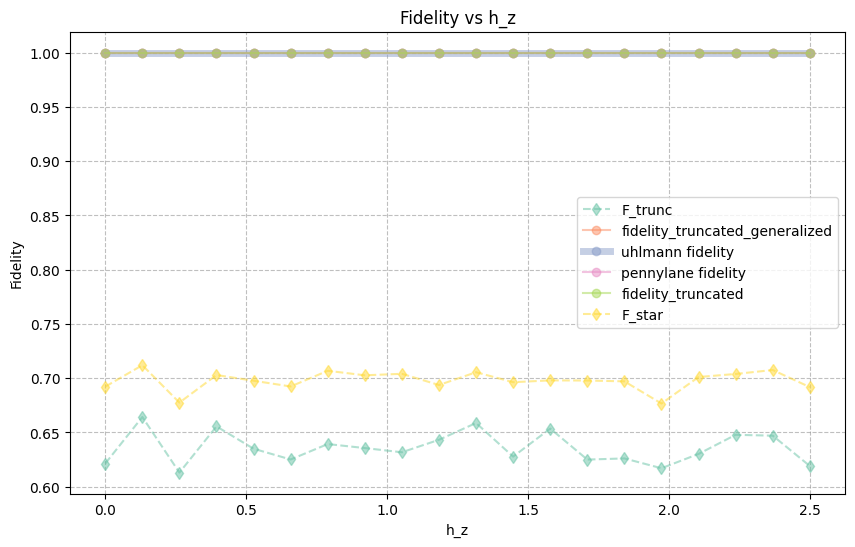

In [11]:
# plot fidelities
import seaborn as sns
sns.set_palette("Set2")
plt.figure(figsize=(10, 6))
plt.plot(df["hz"], df["(Quantum) F_trunc"], label="F_trunc", marker='d', linestyle='--', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated_generalized"], label="fidelity_truncated_generalized", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) uhlmann_fidelity"], label="uhlmann fidelity", marker='o', linewidth=5, alpha=0.5)
plt.plot(df["hz"], df["(Classical) pennylane_fidelity"], label="pennylane fidelity", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated"], label="fidelity_truncated", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Quantum) F_star"], label="F_star", marker='d', linestyle='--', alpha=0.5)
plt.xlabel("h_z")
plt.ylabel("Fidelity")
plt.title("Fidelity vs h_z")
plt.legend()
# use a discomtinuous line style grid
plt.grid(
    linestyle='--',
    color='gray',
    alpha=0.5
)
plt.show()

In [17]:
uhlmann_fidelity = df["(Classical) uhlmann_fidelity"].values
uhlmann_fidelity

array([0.86539583])

In [162]:
# compare states
## parameters
N=3
n=2
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
time_t = 1.0
J=1
delta=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3
trotter_steps_K = 10
trotter_order = 2
print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
#print("h_z =",h_z)
print("h_x =",h_x)
print("delta_h_x =",delta_h_x)
print("delta =",delta)
print("m =",m)
#print("DEBUG is set to: ",DEBUG)
print("trotter_steps_K =",trotter_steps_K)


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]
h_z = 0.1


results = []


# classical fidelity
# classical

#model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG)
print(f"Numerical H:\n{model.construct_hamiltonian()}") 

#rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(
    delta_h_x=delta_h_x,
    trace_out_indices=trace_out_indices,
    time=time_t,)

print(f"purity of rho_mixed: {np.trace(rho_mixed @ rho_mixed)}")
print(f"partcipation ratio of rho_mixed: {1/ np.trace(rho_mixed @ rho_mixed)}")

qobj_numeric_rho = helper_functions.dm_to_qobj(rho_mixed, title="rho_mixed")
qobj_numeric_rho_delta = helper_functions.dm_to_qobj(rho_delta_mixed, title="rho_delta_mixed")

classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, 
                                                     rho_delta_mixed, 
                                                     m, 
                                                     delta, 
                                                     DEBUG=False)

# quantum fidelity

#circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 
# circuit_fn = circuit_generator.make_tfim_circuits(J, 
#                                                   h_x, 
#                                                   delta_h_x, 
#                                                   N, 
#                                                   time_evolution=time_t)

circuit_fn = circuit_generator.make_tfim_circuits_trotter_decomposition(J, 
                                                  h_x, 
                                                  delta_h_x, 
                                                  N, 
                                                  time_evolution=time_t,
                                                  trotter_steps=trotter_steps_K, 
                                                  order=trotter_order)

# IMPORTANT vogliuo rho o rho delta>?
STATE_RHO_OR_RHO_DELTA = "rho_delta" # rho or rho_delta

if STATE_RHO_OR_RHO_DELTA == "rho_delta": 
    print("measuring the density matrix, from the quantum system, for: rho_delta")
    q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho_delta)
elif STATE_RHO_OR_RHO_DELTA == "rho":
    print("measuring the density matrix, from the quantum system, for: rho")
    q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho)
else: 
    raise ValueError("STATE_RHO_OR_RHO_DELTA must be either 'rho' or 'rho_delta'")
# Load a device
dev = qml.device("default.qubit", wires=2 * N)

# Create the QNode for the density matrix circuit
density_matrix_qnode = qml.QNode(q_dm, dev)

# Execute the QNode to get the density matrix
quantum_density_matrix = density_matrix_qnode()
qobj_quantum_circuit = helper_functions.dm_to_qobj(quantum_density_matrix, title="quantum_density_matrix_rho_delta")

print(f"Density matrix of qubits {active_rho}:\n")


# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=m, 
    maxiter= 256)

results.append({
    "hz": h_z,
    "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
    "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
    "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
    "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
    "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
    "(Quantum) F_star" : vqfe_results["F_star"].item(),

})

# quantum fidelity
df = pd.DataFrame(results)


N = 3  starting number of qubits, before tracing out
n = 2  final number of qubits
trace_out_indices = [1]
J = 1
h_x = 0.1
delta_h_x = 0.5
delta = 0.5
m = 1
trotter_steps_K = 10
Numerical H:
[[-2. +0.j -0.1+0.j -0.1+0.j  0. +0.j -0.1+0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.1+0.j  0. +0.j  0. +0.j -0.1+0.j  0. +0.j -0.1+0.j  0. +0.j  0. +0.j]
 [-0.1+0.j  0. +0.j  2. +0.j -0.1+0.j  0. +0.j  0. +0.j -0.1+0.j  0. +0.j]
 [ 0. +0.j -0.1+0.j -0.1+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.1+0.j]
 [-0.1+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.1+0.j -0.1+0.j  0. +0.j]
 [ 0. +0.j -0.1+0.j  0. +0.j  0. +0.j -0.1+0.j  2. +0.j  0. +0.j -0.1+0.j]
 [ 0. +0.j  0. +0.j -0.1+0.j  0. +0.j -0.1+0.j  0. +0.j  0. +0.j -0.1+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.1+0.j  0. +0.j -0.1+0.j -0.1+0.j -2. +0.j]]
purity of rho_mixed: (0.9997637376217577+0j)
partcipation ratio of rho_mixed: (1.000236318211345+0j)
measuring the density matrix, from the quantum system, for: rho_delta
Density matrix of qubits [0, 2]:



In [163]:
print(f"Numerical simulation")
print(qobj_numeric_rho)
print(f"pennylane circuit")
print(qobj_quantum_circuit)

Numerical simulation
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[9.85931857e-01+0.00000000e+00j 6.95993406e-02-4.48105527e-02j
  6.95993406e-02-4.48105527e-02j 2.92308664e-03-6.28157214e-03j]
 [6.95993406e-02+4.48105527e-02j 7.00915090e-03+0.00000000e+00j
  7.00915090e-03-8.74138002e-19j 4.92168439e-04-3.18844774e-04j]
 [6.95993406e-02+4.48105527e-02j 7.00915090e-03+8.74138002e-19j
  7.00915090e-03+0.00000000e+00j 4.92168439e-04-3.18844774e-04j]
 [2.92308664e-03+6.28157214e-03j 4.92168439e-04+3.18844774e-04j
  4.92168439e-04+3.18844774e-04j 4.98413927e-05+0.00000000e+00j]]
pennylane circuit
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5954311 +0.00000000e+00j 0.23862289-1.57346619e-01j
  0.23862289-1.57346619e-01j 0.07889137-9.10478418e-02j]
 [0.23862289+1.57346619e-01j 0.17593965+0.00000000e+00j
  0.17593965+5.93343999e-17j 0.05378555-4.87018649e-02j]
 [0.23862289

In [164]:
qobj_numeric_rho


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[9.85931857e-01+0.00000000e+00j 6.95993406e-02-4.48105527e-02j
  6.95993406e-02-4.48105527e-02j 2.92308664e-03-6.28157214e-03j]
 [6.95993406e-02+4.48105527e-02j 7.00915090e-03+0.00000000e+00j
  7.00915090e-03-8.74138002e-19j 4.92168439e-04-3.18844774e-04j]
 [6.95993406e-02+4.48105527e-02j 7.00915090e-03+8.74138002e-19j
  7.00915090e-03+0.00000000e+00j 4.92168439e-04-3.18844774e-04j]
 [2.92308664e-03+6.28157214e-03j 4.92168439e-04+3.18844774e-04j
  4.92168439e-04+3.18844774e-04j 4.98413927e-05+0.00000000e+00j]]

In [165]:
qobj_quantum_circuit

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5954311 +0.00000000e+00j 0.23862289-1.57346619e-01j
  0.23862289-1.57346619e-01j 0.07889137-9.10478418e-02j]
 [0.23862289+1.57346619e-01j 0.17593965+0.00000000e+00j
  0.17593965+5.93343999e-17j 0.05378555-4.87018649e-02j]
 [0.23862289+1.57346619e-01j 0.17593965-5.93343999e-17j
  0.17593965+0.00000000e+00j 0.05378555-4.87018649e-02j]
 [0.07889137+9.10478418e-02j 0.05378555+4.87018649e-02j
  0.05378555+4.87018649e-02j 0.05268961+0.00000000e+00j]]

In [166]:
qobj_numeric_rho_delta

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.59649185+0.00000000e+00j 0.23895467-1.56927012e-01j
  0.23895467-1.56927012e-01j 0.07884697-9.06936779e-02j]
 [0.23895467+1.56927012e-01j 0.17554072+0.00000000e+00j
  0.17554072+1.56125113e-17j 0.0536132 -4.85093131e-02j]
 [0.23895467+1.56927012e-01j 0.17554072-1.56125113e-17j
  0.17554072+0.00000000e+00j 0.0536132 -4.85093131e-02j]
 [0.07884697+9.06936779e-02j 0.0536132 +4.85093131e-02j
  0.0536132 +4.85093131e-02j 0.05242672+0.00000000e+00j]]

In [167]:
import qutip # Assuming qutip is imported for dm_to_qobj and potentially fidelity calculation

# Calculate fidelity
# For two density matrices rho1 and rho2, the fidelity is F(rho1, rho2) = Tr(sqrt(sqrt(rho1) rho2 sqrt(rho1)))^2
# QuTiP has a built-in function for this.
print(f"IMPORTANT set comparison if rho or rho delta in the circuit")
fidelity = qutip.fidelity(qobj_quantum_circuit, qobj_numeric_rho_delta)

print(f"\nFidelity between numerical and quantum_density_matrix from circuit (CARE see if checking the same rho or rho_delta): {fidelity}")

IMPORTANT set comparison if rho or rho delta in the circuit

Fidelity between numerical and quantum_density_matrix from circuit (CARE see if checking the same rho or rho_delta): 0.9999989200953207


(<Figure size 600x700 with 1 Axes>, <Axes: >)


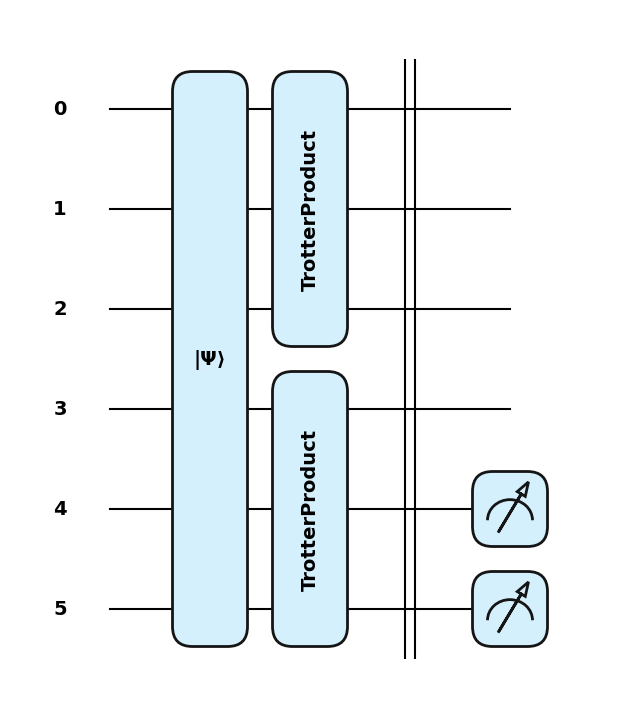

In [121]:
print(qml.draw_mpl(density_matrix_qnode, style="pennylane")())